<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_7_DQN_avec_prioritisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Préparation
---

Assurez-vous d'utiliser un GPU pour ce notebook ! (`GPU` sous `Runtime > Change runtime type > Hardware accelerator`)

In [ ]:
import sys

# Setup for use in Colab
if 'google.colab' in sys.modules:
    !git clone https://github.com/MasterScrat/droneRL-workshop.git --single-branch
    !pip install -r "droneRL-workshop/colab-requirements.txt"
    import os
    os.kill(os.getpid(), 9)
    # Le Runtime va redémarrer après cette étape - c'est normal !

Cloning into 'droneRL-workshop'...
remote: Enumerating objects: 673, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 673 (delta 65), reused 71 (delta 25), pack-reused 543
Receiving objects: 100% (673/673), 22.60 MiB | 23.66 MiB/s, done.
Resolving deltas: 100% (391/391), done.


In [1]:
%cd droneRL-workshop

/content/droneRL-workshop


In [2]:
import datetime
import os
import numpy as np

from agents.dqn import DQNAgent, ConvQNetworkFactory, ConvQNetwork
from agents.curiosity import CuriosityDQNAgent
from agents.random import RandomAgent
from agents.logging import TensorBoardLogger, NoLogger
from agents.per import PERAgent
from env.env import DeliveryDrones
from env.wrappers import WindowedGridView
from helpers.rl_helpers import MultiAgentTrainer, plot_rolling_rewards, test_agents, plot_cumulative_rewards, render_video, set_seed, ColabVideo

## DQN avec prioritisation

In [29]:
env = WindowedGridView(DeliveryDrones(), radius=3)

# Parameters utilisé pour l'évaluation sur AIcrowd
env.env_params.update({
    'charge': 20,
    'charge_reward': -0.1,
    'crash_reward': -1,
    'delivery_reward': 1,
    'discharge': 10,
    'drone_density': 0.05,
    'dropzones_factor': 2,
    'n_drones': 10,
    'packets_factor': 3,
    'pickup_reward': 0,
    'rgb_render_rescale': 1.0,
    'skyscrapers_factor': 3,
    'stations_factor': 2
})

In [30]:
# On crée 2 agents DQN "standards"
dqn_agent_1 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[64, 64]),
    gamma=0.95, epsilon_start=1, epsilon_decay=0.9, epsilon_end=0.01, memory_size=10000, batch_size=64,
    target_update_interval=50)

dqn_agent_2 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[64, 64]),
    gamma=0.95, epsilon_start=1, epsilon_decay=0.9, epsilon_end=0.01, memory_size=10000, batch_size=64,
    target_update_interval=50)

Training agents: 100%|█████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.55it/s]


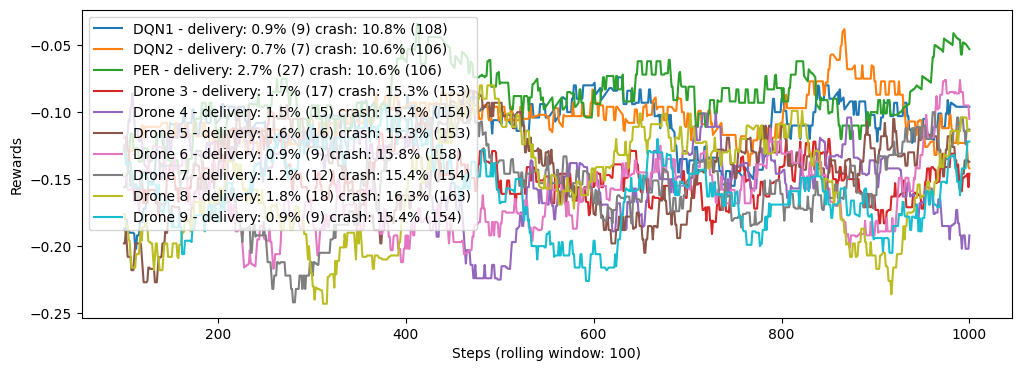

In [31]:
# On crée un agent DQN avec prioritisation (PER = Prioritized Experience Replay)
conv_factory = ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[64, 64])

per_agent_1 = PERAgent(env,
                       conv_factory,
                       gamma=0.95,
                       epsilon_start=1.0,
                       epsilon_decay=0.9,
                       epsilon_end=0.01,
                       memory_size=10000,
                       batch_size=64,
                       target_update_interval=50,
                       alpha=0.6,
                       beta=0.4)

# Reset de l'environnement
env.reset()

# Setup random opponents
agents = {drone.index: RandomAgent(env) for drone in env.drones}

# On ajoute les drones DQN
agents[0] = dqn_agent_1
agents[1] = dqn_agent_2
agents[2] = per_agent_1

# On crée le trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)

# Et on entraine !
trainer.train(1000)
rewards = plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'PER'})

Training agents: 100%|███████████████████████████████████████| 10000/10000 [03:14<00:00, 51.39it/s]


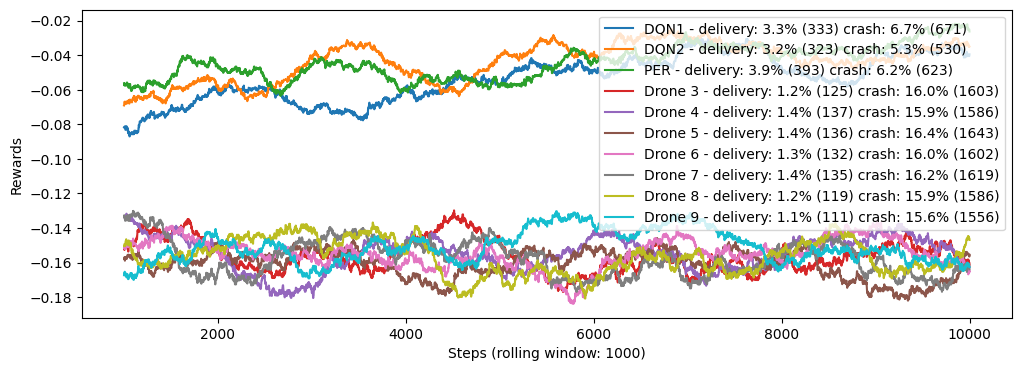

In [35]:
# On crée le trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=False, seed=0)

# Et on entraine !
trainer.train(10000)
rewards = plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'PER'})

Testing agents: 100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.34it/s]


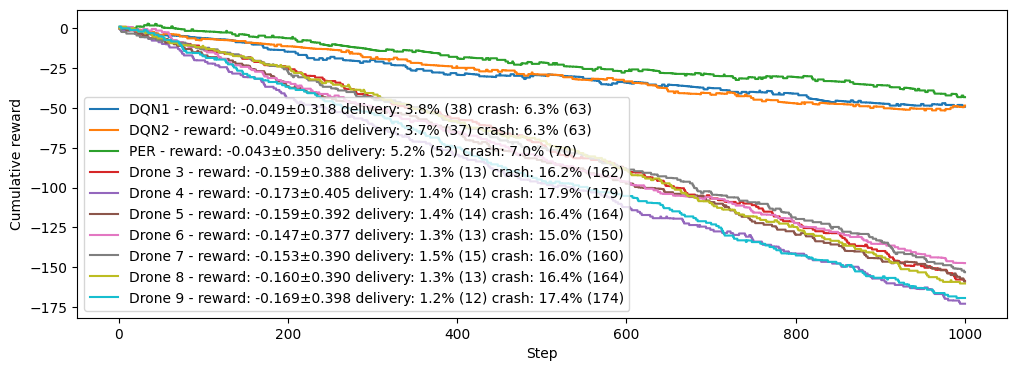

Agent 0: -49.2
Agent 1: -48.5
Agent 2: -43.2
Agent 3: -158.7
Agent 4: -172.89999999999998
Agent 5: -159.0
Agent 6: -147.4
Agent 7: -153.1
Agent 8: -160.2
Agent 9: -169.3


In [36]:
# Evaluation
rewards_log = test_agents(env, agents, n_steps=1000)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'PER'})

# Evaluations finales
for idx, score in enumerate(np.sum(list(rewards_log.values()), axis=1)):
    print("Agent {}: {}".format(idx, score))

In [ ]:
# On sauve la video si besoin
path = os.path.join('videos', 'prioritized.mp4')
#render_video(env, agents, path, n_steps=60, fps=1, seed=None)

In [41]:
# On sauve l'agent
path = os.path.join('output', 'agents', 'prioritized-agent.pt')
per_agent_1.save(path)

**Expérimentez un peu puis envoyez vos agents sur AIcrowd!** 🚀

https://www.aicrowd.com/challenges/dronerl